In [1]:
import os
import cv2
import glob
import keras
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.models import Model
import matplotlib.pyplot as plt
from sklearn.utils import resample
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import f1_score, precision_score, recall_score
from keras.layers import Conv2D, Dense, Dropout, GlobalAveragePooling2D, MaxPool2D
import warnings
warnings.filterwarnings('ignore')
import logging
# Set TensorFlow log level to only display errors
tf.get_logger().setLevel(logging.ERROR)

2024-06-13 23:23:39.623017: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-13 23:23:40.842081: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
data_dir = 'chest-xray-dataset'
paths = glob.glob(data_dir + '/*/*/*.jpeg')
print(f'found {len(paths)} images in the dataset')
paths[:5]

found 5856 images in the dataset


['chest-xray-dataset/val/PNEUMONIA/person1954_bacteria_4886.jpeg',
 'chest-xray-dataset/val/PNEUMONIA/person1947_bacteria_4876.jpeg',
 'chest-xray-dataset/val/PNEUMONIA/person1946_bacteria_4874.jpeg',
 'chest-xray-dataset/val/PNEUMONIA/person1951_bacteria_4882.jpeg',
 'chest-xray-dataset/val/PNEUMONIA/person1952_bacteria_4883.jpeg']

In [3]:
df = pd.DataFrame(paths, columns=['path'])

# Function to get label from path
def get_label(path):
    parts = path.split(os.path.sep)
    # Find label by searching from the end of the path
    for part in reversed(parts):
        if part in ['NORMAL', 'PNEUMONIA']:  # Assuming these are the labels
            return part
    return None

df['label'] = df['path'].apply(get_label)
df.head()

,path,label
0,chest-xray-dataset/val/PNEUMONIA/person1954_ba...,PNEUMONIA
1,chest-xray-dataset/val/PNEUMONIA/person1947_ba...,PNEUMONIA
2,chest-xray-dataset/val/PNEUMONIA/person1946_ba...,PNEUMONIA
3,chest-xray-dataset/val/PNEUMONIA/person1951_ba...,PNEUMONIA
4,chest-xray-dataset/val/PNEUMONIA/person1952_ba...,PNEUMONIA


In [4]:
counts=df['label'].value_counts()
counts

label
PNEUMONIA    4273
NORMAL       1583
Name: count, dtype: int64

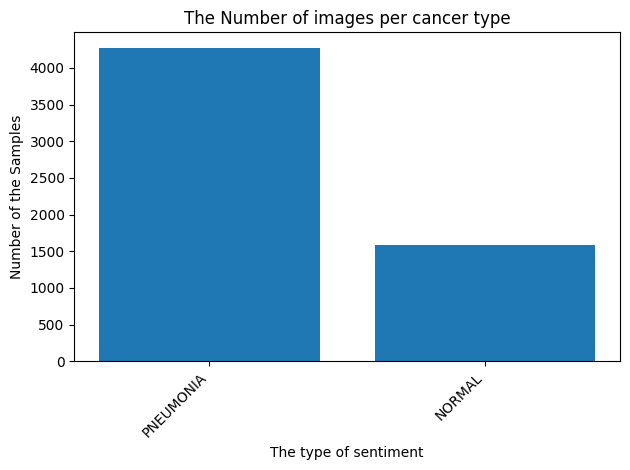

In [5]:
plt.bar(['PNEUMONIA','NORMAL'], counts, width=0.8)
plt.xlabel('The type of sentiment')
plt.ylabel('Number of the Samples')
plt.title("The Number of images per cancer type")
plt.xticks(rotation=45, ha='right') 
plt.tight_layout() 
plt.show()

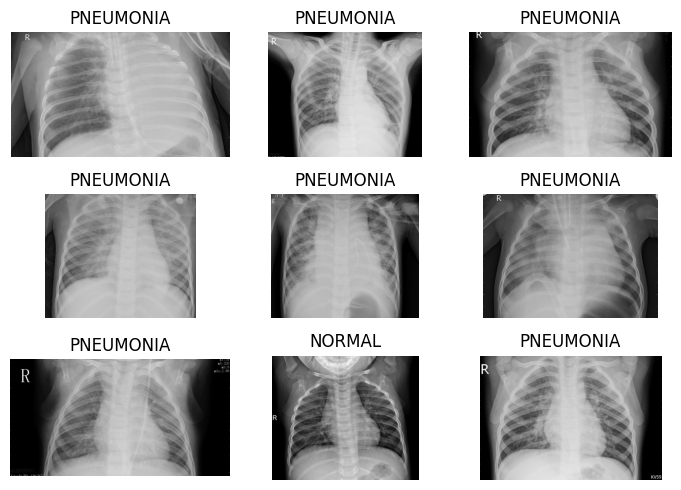

In [6]:
num_images=9
# Randomly sample num_images from the DataFrame
sampled_df = df.sample(n=num_images).reset_index(drop=True)

plt.figure(figsize=(7, 5))
for i in range(num_images):
    plt.subplot(3, 3, i + 1)

    # Read the image
    img_path = sampled_df.iloc[i]['path']
    img = plt.imread(img_path)

    plt.imshow(img,cmap='gray')
    plt.title(sampled_df.iloc[i]['label'])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [7]:
df_majority = df[df.label == 'PNEUMONIA']
df_minority = df[df.label == 'NORMAL']

In [8]:
# Downsample majority class
df_majority_downsampled = resample(df_majority,
                                   replace=False,  
                                   n_samples=len(df_minority), 
                                   random_state=42)  

# Combine minority class with downsampled majority class
df = pd.concat([df_minority, df_majority_downsampled])

In [9]:
counts=df['label'].value_counts()
counts

label
NORMAL       1583
PNEUMONIA    1583
Name: count, dtype: int64

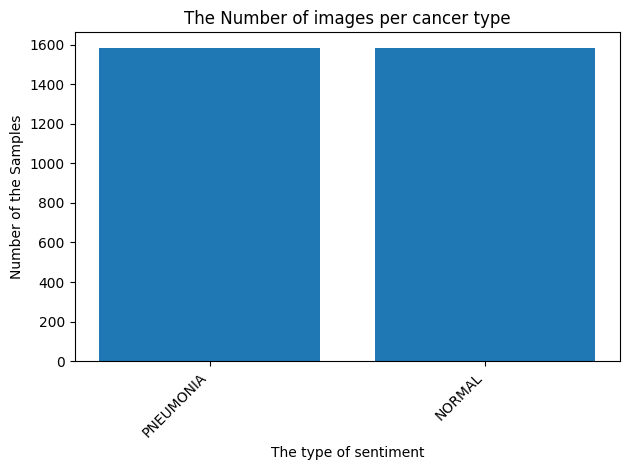

In [10]:
plt.bar(['PNEUMONIA','NORMAL'], counts, width=0.8)
plt.xlabel('The type of sentiment')
plt.ylabel('Number of the Samples')
plt.title("The Number of images per cancer type")
plt.xticks(rotation=45, ha='right') 
plt.tight_layout() 
plt.show()

In [11]:
df

,path,label
8,chest-xray-dataset/val/NORMAL/NORMAL2-IM-1440-...,NORMAL
9,chest-xray-dataset/val/NORMAL/NORMAL2-IM-1427-...,NORMAL
10,chest-xray-dataset/val/NORMAL/NORMAL2-IM-1436-...,NORMAL
11,chest-xray-dataset/val/NORMAL/NORMAL2-IM-1431-...,NORMAL
12,chest-xray-dataset/val/NORMAL/NORMAL2-IM-1438-...,NORMAL
...,...,...
5580,chest-xray-dataset/test/PNEUMONIA/person86_bac...,PNEUMONIA
3540,chest-xray-dataset/train/PNEUMONIA/person1488_...,PNEUMONIA
3547,chest-xray-dataset/train/PNEUMONIA/person1426_...,PNEUMONIA
3136,chest-xray-dataset/train/PNEUMONIA/person809_b...,PNEUMONIA


In [12]:
df['label'] = df['label'].apply(lambda x: '1' if x == 'PNEUMONIA' else '0')
df.head()

,path,label
8,chest-xray-dataset/val/NORMAL/NORMAL2-IM-1440-...,0
9,chest-xray-dataset/val/NORMAL/NORMAL2-IM-1427-...,0
10,chest-xray-dataset/val/NORMAL/NORMAL2-IM-1436-...,0
11,chest-xray-dataset/val/NORMAL/NORMAL2-IM-1431-...,0
12,chest-xray-dataset/val/NORMAL/NORMAL2-IM-1438-...,0


In [13]:
df['label'].value_counts()

label
0    1583
1    1583
Name: count, dtype: int64

In [14]:
df=df.sample(frac=1.0, random_state=42)
df.head(5)

,path,label
4447,chest-xray-dataset/train/NORMAL/IM-0160-0001.jpeg,0
5213,chest-xray-dataset/train/NORMAL/IM-0524-0001.jpeg,0
4053,chest-xray-dataset/train/NORMAL/IM-0316-0001.jpeg,0
867,chest-xray-dataset/train/PNEUMONIA/person502_b...,1
117,chest-xray-dataset/train/PNEUMONIA/person1243_...,1


In [15]:
# Splitting data
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
test_df, valid_df = train_test_split(temp_df, test_size=0.5, random_state=42)
print("Training set shapes:", train_df.shape)
print("Validation set shapes:", valid_df.shape)
print("Testing set shapes:", test_df.shape)

Training set shapes: (2532, 2)
Validation set shapes: (317, 2)
Testing set shapes: (317, 2)


In [16]:
train_df['label'].value_counts()

label
1    1277
0    1255
Name: count, dtype: int64

In [17]:
train_datagen = ImageDataGenerator(    
    rescale=1.0/255,        
#     shear_range=0.2,
#     rotation_range=.1,
#     zoom_range=0.2,       
#     horizontal_flip=True ,
)
test_datagen = ImageDataGenerator(rescale=1./255)

In [18]:
# Training data generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path', 
    y_col='label',   
    target_size=(150, 150), 
    batch_size=32,
    class_mode='binary', 
    color_mode='rgb',
    shuffle=True
)

# Validation data generator
valid_generator = test_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='path', 
    y_col='label',
    target_size=(150, 150), 
    batch_size=32,
    color_mode='rgb',
    class_mode='binary',
    shuffle=False  
)

# Testing data generator
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='path', 
    y_col='label',  
    target_size=(150, 150),  
    color_mode='rgb',
    batch_size=64,  
    class_mode='binary',
    shuffle=False  
)

Found 2532 validated image filenames belonging to 2 classes.
Found 317 validated image filenames belonging to 2 classes.


Found 317 validated image filenames belonging to 2 classes.


In [19]:
classes=['NORMAL','PNEUMONIA']
classes

['NORMAL', 'PNEUMONIA']

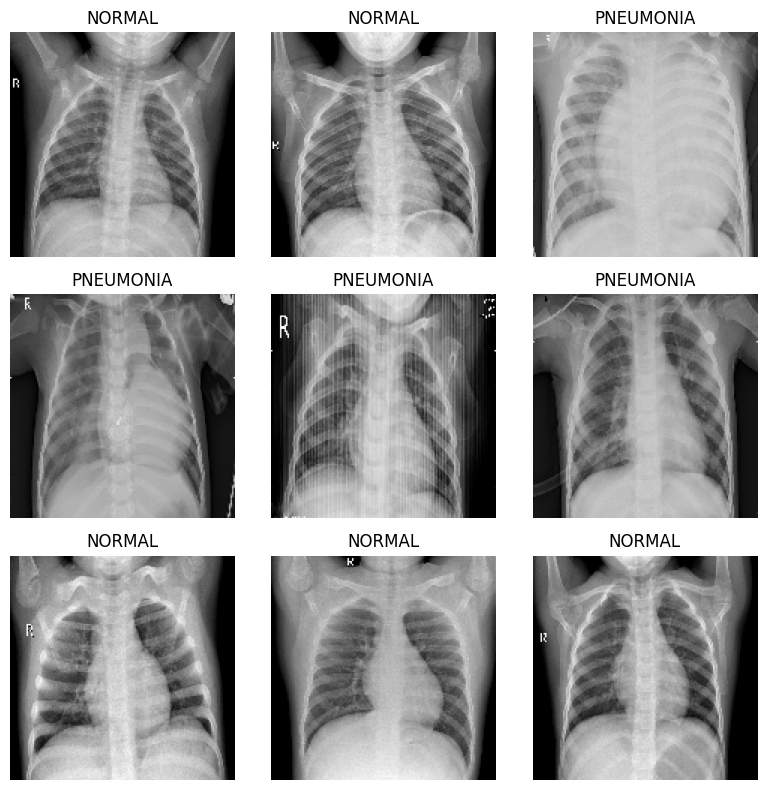

In [20]:
batch_size = 9
# Generate a batch of images and labels
images, labels = next(train_generator)
# Plot the images with their labels
plt.figure(figsize=(8, 8))
for i in range(min(len(images), 9)):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i],cmap='gray')
    plt.title(f"{classes[int(labels[i])]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [21]:
train_generator.image_shape

(150, 150, 3)

In [22]:
from keras.applications import MobileNetV2
mobileNetV2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze pretrained layers
for layer in mobileNetV2.layers:
    layer.trainable = False

2024-06-13 23:23:46.742046: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-13 23:23:46.921736: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [23]:
mobileNet=keras.models.Sequential([
    mobileNetV2,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'), 
    Dropout(0.5),  
    Dense(1, activation='sigmoid') 
])

mobileNet.add(Dense(1,activation='sigmoid'))
mobileNet.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [24]:
mobileNet.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ ?                      │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [25]:
weight_path = "cnn_weights.best.weights.h5"

checkpoint = ModelCheckpoint(weight_path, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only=True)

early = EarlyStopping(monitor="val_accuracy", 
                      mode="max", 
                      patience=4)

callbacks_list = [checkpoint, early]

In [26]:
mobileNet_history=mobileNet.fit(train_generator,epochs=5,validation_data=valid_generator,callbacks=callbacks_list)

Epoch 1/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/step - accuracy: 0.7194 - loss: 0.6214
Epoch 1: val_accuracy improved from -inf to 0.92114, saving model to cnn_weights.best.weights.h5
80/80 ━━━━━━━━━━━━━━━━━━━━ 59s 648ms/step - accuracy: 0.7206 - loss: 0.6211 - val_accuracy: 0.9211 - val_loss: 0.5782
Epoch 2/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 536ms/step - accuracy: 0.9119 - loss: 0.5739
Epoch 2: val_accuracy improved from 0.92114 to 0.93060, saving model to cnn_weights.best.weights.h5
80/80 ━━━━━━━━━━━━━━━━━━━━ 51s 610ms/step - accuracy: 0.9120 - loss: 0.5738 - val_accuracy: 0.9306 - val_loss: 0.5607
Epoch 3/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.9255 - loss: 0.5580
Epoch 3: val_accuracy improved from 0.93060 to 0.94322, saving model to cnn_weights.best.weights.h5
80/80 ━━━━━━━━━━━━━━━━━━━━ 50s 604ms/step - accuracy: 0.9254 - loss: 0.5580 - val_accuracy: 0.9432 - val_loss: 0.5467
Epoch 4/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - accuracy: 0.9233 - loss: 0.5509
Epoch 4: 

In [27]:
# load the best weights
mobileNet.load_weights(weight_path)

In [28]:
# Evaluate the model on the test data
evaluation_result = mobileNet.evaluate(test_generator)

# The result
print("Test Loss:", evaluation_result[0])
print("Test Accuracy:", evaluation_result[1])

2024-06-13 23:28:07.385318: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 138240000 exceeds 10% of free system memory.
2024-06-13 23:28:07.493823: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 145711104 exceeds 10% of free system memory.


1/5 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.9844 - loss: 0.5488

2024-06-13 23:28:08.563272: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 138240000 exceeds 10% of free system memory.
2024-06-13 23:28:08.692393: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 145711104 exceeds 10% of free system memory.


2/5 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.9727 - loss: 0.5462

2024-06-13 23:28:09.730546: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 138240000 exceeds 10% of free system memory.


5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9426 - loss: 0.5502
Test Loss: 0.5554768443107605
Test Accuracy: 0.9242902398109436


In [29]:
y_pred = mobileNet.predict(test_generator)

5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step


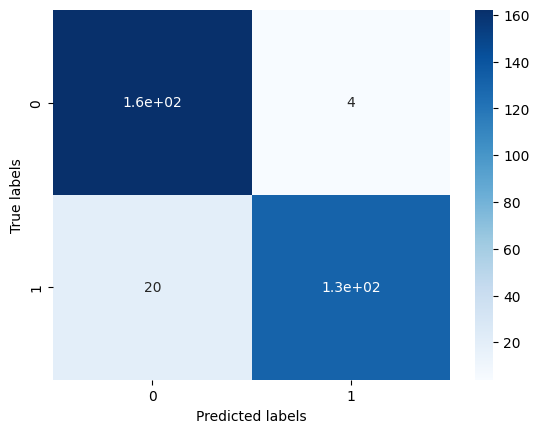

In [30]:
y_pred_binary = np.squeeze(np.round(y_pred))
# confusion matrix
confusion_Matrix = confusion_matrix(test_generator.classes, y_pred_binary)
confusion_Matrix

sns.heatmap(confusion_Matrix, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

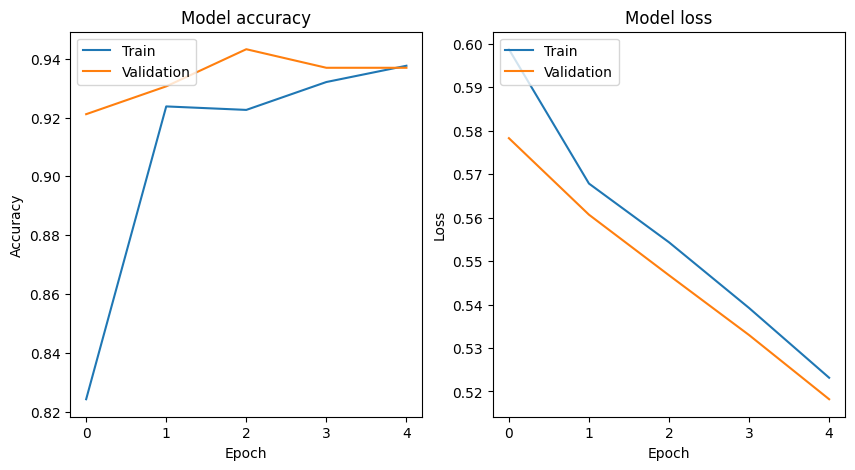

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
# Plot the training and validation accuracy
ax1.plot(mobileNet_history.history['accuracy'])
ax1.plot(mobileNet_history.history['val_accuracy'])
ax1.set_title('Model accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')

# Plot the training and validation loss
ax2.plot(mobileNet_history.history['loss'])
ax2.plot(mobileNet_history.history['val_loss'])
ax2.set_title('Model loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper left')

# Display the plots
plt.show()

In [32]:
mobilenet_pred_binary = np.squeeze(np.round(y_pred))
print(classification_report(test_generator.classes, mobilenet_pred_binary))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93       166
           1       0.97      0.87      0.92       151

    accuracy                           0.92       317
   macro avg       0.93      0.92      0.92       317
weighted avg       0.93      0.92      0.92       317



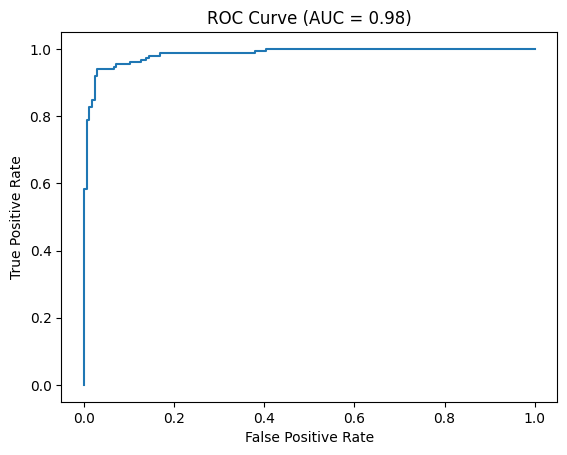

In [33]:
from sklearn.metrics import roc_curve, roc_auc_score


# Compute the FPR, TPR, and thresholds for various classification thresholds
fpr, tpr, thresholds = roc_curve(test_generator.classes, y_pred)

# Compute the AUC score
auc_score = roc_auc_score(test_generator.classes, y_pred)

# Plot the ROC curve
import matplotlib.pyplot as plt
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (AUC = {auc_score:.2f})')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


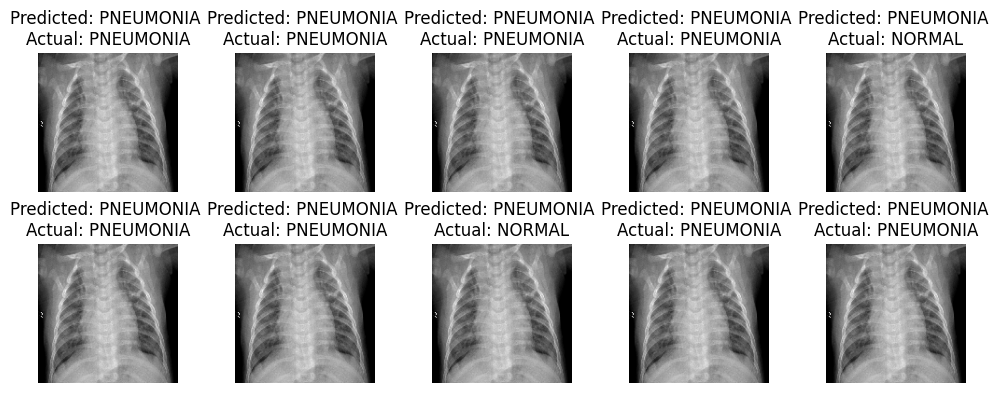

In [34]:
x_test,y_test=next(test_generator)
fig, axs = plt.subplots(2, 5, figsize=(10, 4))
axs = axs.flatten()

testimgnum = 0 # Atur nilai testimgnum sebelum loop
for i in range(10):
    predicted = mobileNet.predict(np.array([x_test[testimgnum]]))
    predictedClass = int(predicted >= 0.5)
    actual = int(y_test[i])

    axs[i].imshow(x_test[testimgnum], cmap='gray')
    axs[i].set_title(f'Predicted: {classes[predictedClass]} \nActual: {classes[actual]}')
    axs[i].axis('off')

plt.tight_layout()
plt.show()

In [35]:
# Python code to save the model in Keras
from keras.models import load_model

# Simpan model ke dalam file .h5
mobileNet.save('model.h5')


In [38]:

import tensorflow as tf
#import tensorflowjs as tfjs

mobileNet = tf.keras.models.load_model('model.h5')
tf.saved_model.save(mobileNet, 'saved_model')
#tfjs.converters.save_keras_model(mobileNet, 'mobileNet_model')


In [37]:
#import keras
#import tensorflowjs as tfjs

#mobileNet = keras.applications.mobilenet.MobileNet(alpha=0.25)

#tfjs.converters.save_keras_model(mobileNet, 'mobileNet_model')

2108140/2108140 ━━━━━━━━━━━━━━━━━━━━ 4s 2us/step


failed to lookup keras version from the file,
    this is likely a weight only file
